<a href="https://colab.research.google.com/github/Folasewa/Azure_Data_Science_Learn/blob/main/Dogs_Vs_Cats_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importing all packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
#@title Data Loading
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
#@title Listing the directories
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # directory with training cats pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # directory with training dogs pictures
val_cats_dir = os.path.join(validation_dir, 'cats')#directory with validation cats pictures
val_dogs_dir = os.path.join(validation_dir, 'dogs')# directory with validation dogs pictures

In [5]:
#@title Understanding our Data
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))

num_train = num_cats_train + num_dogs_train
num_val = num_cats_val + num_dogs_val

print("The total training images of cats", num_cats_train)
print("The total training images of dogs", num_dogs_train)
print("The total validation images of cats", num_cats_val)
print("The total validation images of dogs", num_dogs_val)
print("The total available training images", num_train)
print("The total available validation images", num_val)

The total training images of cats 1000
The total training images of dogs 1000
The total validation images of cats 500
The total validation images of dogs 500
The total available training images 2000
The total available validation images 1000


In [6]:
#@title Setting Model Parameters
BATCH_SIZE = 32
IMG_SHAPE = 150

In [7]:
#@title Data Preparation
train_image_generator = ImageDataGenerator(rescale = 1./255)
val_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

val_data_gen = val_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                       directory = validation_dir,
                                                       shuffle = False,
                                                       target_size = (IMG_SHAPE, IMG_SHAPE),
                                                       class_mode = 'binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


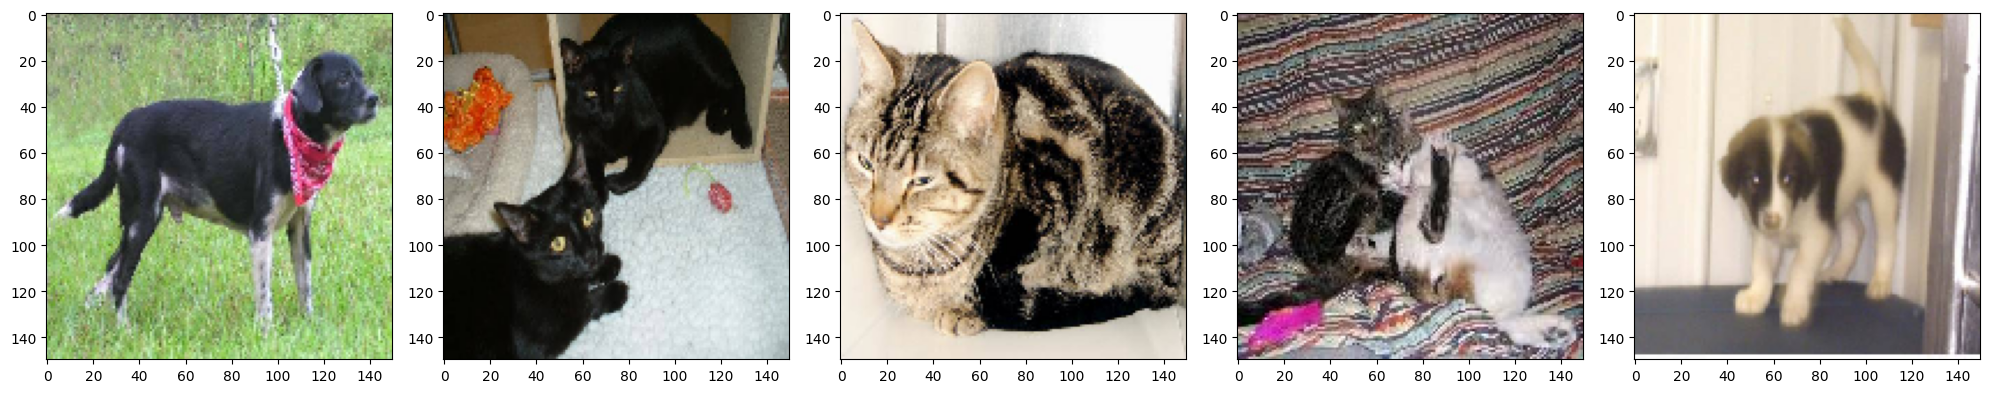

In [8]:
#@title Visualizing Training Images
#The next function returns a batch from the dataset.
sample_training_images, _ = next(train_data_gen)

#plotting images in form of a grid of 1 row and 5 columns

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

In [9]:
#@title Defining the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2,activation = 'softmax')  # Assuming binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
#@title Compile the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
#@title Summary of the model
#looking at all the layers of our model using summary method
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
num_val = 200  # Example number of validation samples
validation_steps = int(np.ceil(num_val / float(BATCH_SIZE)))
print(validation_steps)

7


In [13]:
x_val, y_val = next(val_data_gen)
print(f'Validation Batch shape: {x_val.shape}, Labels shape: {y_val.shape}')


Validation Batch shape: (32, 150, 150, 3), Labels shape: (32,)


In [14]:
x, y = next(train_data_gen)
print(f'Batch shape: {x.shape}, Labels shape: {y.shape}')  # Ensure shapes are as expected


Batch shape: (32, 150, 150, 3), Labels shape: (32,)


In [15]:
#@title Train the model
EPOCHS = 20
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(num_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(num_val / float(BATCH_SIZE)))
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4977 - loss: 0.8375 - val_accuracy: 0.0893 - val_loss: 0.7487
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0804 - val_loss: 0.7551
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5705 - loss: 0.6853 - val_accuracy: 0.6920 - val_loss: 0.6153
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6920 - val_loss: 0.6199
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.6671 - loss: 0.6343 - val_accuracy: 0.7500 - val_loss: 0.5149
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4286 - val_loss: 0.7511
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7139 - loss: 0.5547 - val_accuracy: 0.6518 - val_loss: 0.6361
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7277 - val_loss: 0.5263
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7616 - loss: 0.4964 - val

In [16]:
#@title Visualizing the result

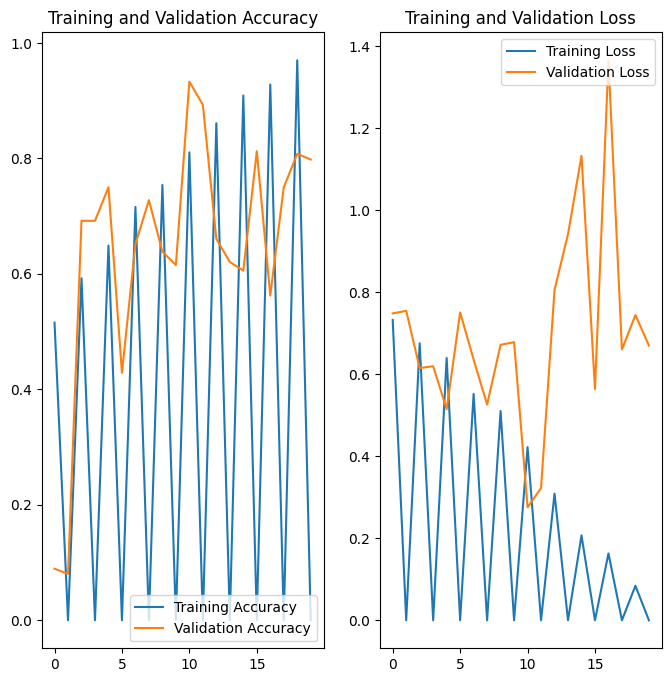

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()